# StanfordTPCAnalysis Tutorial

### Table of Contents:

1. [Getting Started](#gettingstarted) 
2. [How to import StanfordTPCAnalysis modules](#importmodules)
3. [Using the `StruckAnalysisConfiguration` class](#struckanalysisconfiguration)
4. [Accessing the reduced data](#accessing)
    1. [Looking at all the variables in the data tree](#allvariables)
5. [Analyzing the reduced data](#analyzing)
6. [Inspecting waveforms in the raw data](#inspectingwaveforms)


<a id="gettingstarted"></a>


# Getting started


The data pipeline from the Stanford TPC uses a piece of in-house software called `StanfordTPCAnalysis`, which processes the waveform-level data from the TPC and produced reduced data that can be more easily analyzed. This tutorial is intended to some examples on how to analyze the reduced data. 

#### StanfordTPCAnalysis

It's often useful, even after the data processing, to have access to some of the `StanfordTPCAnalysis` python modules. To get started, you'll need to install a few python packages that StanfordTPCAnalysis requires and also make analyzing the data a bit easier. The dependencies for StanfordTPCAnalysis are listed on the GitHub page:
https://github.com/bglenardo/StanfordTPCAnalysis
and should be easily installed using `pip install`. 

#### Pandas

To do the analysis, you'll definitely need `pandas`, as all of our data is stored in `pandas.DataFrame()` objects. Documentation on the `pandas` library is located on their website. Probably a good place to start is in their tutorials: 
https://pandas.pydata.org/docs/getting_started/intro_tutorials/02_read_write.html

#### Histlite

Histlite is a python package written by former nEXO-er Mike Richman. It provides an easy interface for making both 1-D and 2-D histograms, similar to what one can do with ROOT at the command line. You can find more info on the `readthedocs` web page: 
https://histlite.readthedocs.io/en/latest/
and can install the package using `pip install`. This package isn't a necessary dependency, but will be used in the tutorial below.



# Import relevant libraries


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cycler

import histlite as hl

import sys
sys.path.append('/g/g20/lenardo1/software/')
from StanfordTPCAnalysis.StruckAnalysisConfiguration import StruckAnalysisConfiguration

import os

plt.rcParams['axes.prop_cycle'] = cycler.cycler(color='bgrmyk')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

import time

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 12



<a id="importmodules"></a>

# How to import StanfordTPCAnalysis modules?

The StanfordTPCAnalysis code is located on GitHub: https://github.com/bglenardo/StanfordTPCAnalysis

There are two ways to make sure your analysis code has access to the StanfordTPCAnalysis modules:
1. Append the directory where the StanfordTPCAnalysis folder is located to `sys.path`
2. Add the directory where the StanfordTPCAnalysis folder is located to your `PYTHONPATH` environment variable.

Since this notebook should be self-contained, we'll go with option 1 below:


In [3]:
#to import the custom modules you need to access the StanfordTPCAnalysis.* folder,
#the code of the modules can be found on the TMS github repository
import sys

path_to_StanfordTPCAnalysis = '/g/g20/lenardo1/software'
sys.path.append( path_to_StanfordTPCAnalysis )


In [4]:
# StruckAnalysisConfiguration class organizes all the metadata from each run. 

from StanfordTPCAnalysis.StruckAnalysisConfiguration import StruckAnalysisConfiguration

# The Waveform class has some tools to draw waveforms for each event.

from StanfordTPCAnalysis.WaveformAnalysis import Waveform



<a id="struckanalysisconfiguration"></a>

# Using the StruckAnalysisConfiguration class

The `StruckAnalysisConfiguration` class organizes all the metadata from each run. Below we show how to load in the RunParameters and ChannelMap information, which may be useful during analysis.

In [5]:
#all the run configuration paramenters are stored in these three files
run_parameters_file = '/g/g20/lenardo1/software/StanfordTPCAnalysis/config/Run_Parameters_Xe_Run29.csv'
calibrations_file = '/g/g20/lenardo1/software/StanfordTPCAnalysis/config/Calibrations_Xe_Run11b.csv'
channel_map_file = '/g/g20/lenardo1/software/StanfordTPCAnalysis/config/Channel_Map_Xe_Run29.csv'


#analysis_config object loads all these paramenters
analysis_config = StruckAnalysisConfiguration.StruckAnalysisConfiguration()

analysis_config.GetRunParametersFromFile( run_parameters_file )
analysis_config.GetChannelMapFromFile( channel_map_file )




### Run parameters:

In [6]:
# RunParameters are stored as a python dict object

for parameter, value in analysis_config.run_parameters.items():
    print( '{:<25}\t{:>10.6}'.format( parameter+':', float(value) ) )

    
    
sampling_period_us = analysis_config.run_parameters['Sampling Period [ns]'] / 1.e3 # Convert from ns to us
trigger_time_samples = analysis_config.run_parameters['Pretrigger Length [samples]']
waveform_length_samples = analysis_config.run_parameters['Waveform Length [samples]']


Sampling Rate [MHz]:     	      62.5
Drift Length [mm]:       	     140.0
Drift Velocity [mm/us]:  	      1.79
Num Struck Boards:       	       2.0
Waveform Length [samples]:	    6500.0
Pretrigger Length [samples]:	    1000.0
Baseline Length [samples]:	     500.0
Strip Threshold [sigma]: 	       5.0
Max Drift Time [us]:     	   78.2123
Sampling Period [ns]:    	      16.0
Baseline Average Time [us]:	       8.0
Energy Start Time [us]:  	      96.0
Decay Start Time [us]:   	      96.0
Decay End Time [us]:     	     596.0
Decay Guess [us]:        	     200.0
DoInvert:                	       0.0


### Channel Map:


In [7]:
# The ChannelMap is stored as a pandas DataFramwe()
analysis_config.channel_map.head(n=32)


,Board,InputChannel,SoftwareChannel,ChannelType,ChannelName,NumDevicesInChannel,IsAmplified,IsDead,ChannelPosX,ChannelPosY,MCChannelMap
0,0,0,0,TileStrip,X1-12,12,True,False,-25.5,0.0,0.0
1,0,1,1,TileStrip,X13,1,True,False,-7.5,0.0,0.0
2,0,2,2,TileStrip,X14,1,True,False,-4.5,0.0,0.0
3,0,3,3,TileStrip,X15,1,True,False,-1.5,0.0,0.0
4,0,4,4,TileStrip,X16,1,True,False,1.5,0.0,0.0
5,0,5,5,TileStrip,X17,1,True,False,4.5,0.0,0.0
6,0,6,6,TileStrip,X18,1,True,False,7.5,0.0,0.0
7,0,7,7,TileStrip,X19,1,True,False,10.5,0.0,0.0
8,0,8,8,TileStrip,X20,1,True,False,13.5,0.0,0.0
9,0,9,9,TileStrip,X21,1,True,False,16.5,0.0,0.0


<a id="accessing"></a>


# Accessing the reduced data

The reduced (a.k.a. "processed") data are stored in `pandas.DataFrame` objects, which are in turn either stored in `HDF5` or `pickle` files. In this example, we'll use data from Run29, which are stored in `HDF5` file format and can be retrieved using the `pandas.read_hdf` method.



In [8]:
#if you ls into /p/lustre1/jacopod/29th/ you can find the reconstructed data in analysis*
#where the * is for the different smoothing window, here I access 500ns as example

path_to_reduced_data = '/p/lustre1/jacopod/29th/analysis_500ns/'

# You can see there are several different datasets stored in this directory.
!ls $path_to_reduced

Clustering     ParseSimulation	scripts			     Tutorials
config	       ParseStruck	setup.sh		     WaveformAnalysis
DataReduction  ParseWavedump	StruckAnalysisConfiguration
__init__.py    __pycache__	StanfordTPCAnalysis Tutorial.ipynb
OldFiles       README.md	TMSUtilities


In [9]:
# We'll load in the dataset from after the Rn220 injection. It will be stored
# in a pandas DataFrame object called "data_df"

fname = path_to_reduced_data + '20200213_AfterRnInjection/reduced_added.h5'
data_df = pd.read_hdf(fname)
data_df.head()



,ChannelPositions,ChannelTypes,Cluster Drift Time,Cluster Energies,Cluster X-Pos,Cluster Y-Pos,Cluster Z-Pos,Event,File,IsFull3D,...,Timestamp,TotalSiPMEnergy,TotalTileEnergy,Weighted Event Size X,Weighted Event Size Y,Weighted Event Size Z,WeightedDriftTime,WeightedPosX,WeightedPosY,WeightedPosZ
0,"[-25, 42, -4, 18, 7, -13, 30, -7, 42, -1, 13, ...","[TileStrip, TileStrip, TileStrip, TileStrip, T...","[61.61599999999999, 53.76]","[1107.181193828974, 229.52235859292406]","[-4.5, 1.5]","[-999.0, -999.0]","[110.29263999999999, 96.2304]",0.0,tier1_SIS3316Raw_20200214131350_SiPMs_longTPC_...,0.0,...,"[1573576, 1573576, 1573576, 1573576, 1573576, ...",22435.075998,1336.703552,1.206812e+00,0.000000,2.828414e+00,60.267064,-3.469754,-999.000000,107.878044
1,"[-25, 42, -4, 18, 7, -13, 30, -7, 42, -1, 13, ...","[TileStrip, TileStrip, TileStrip, TileStrip, T...",[],[],[],[],[],1.0,tier1_SIS3316Raw_20200214131350_SiPMs_longTPC_...,1.0,...,"[2949720, 2949720, 2949720, 2949720, 2949720, ...",28482.519959,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,-999.000000,-999.000000,0.000000
2,"[-25, 42, -4, 18, 7, -13, 30, -7, 42, -1, 13, ...","[TileStrip, TileStrip, TileStrip, TileStrip, T...",[],[],[],[],[],2.0,tier1_SIS3316Raw_20200214131350_SiPMs_longTPC_...,1.0,...,"[5038977, 5038977, 5038977, 5038977, 5038977, ...",9633.111125,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,-999.000000,-999.000000,0.000000
3,"[-25, 42, -4, 18, 7, -13, 30, -7, 42, -1, 13, ...","[TileStrip, TileStrip, TileStrip, TileStrip, T...","[6.160000000000001, 63.312000000000005, 69.184...","[47.36281235620749, 81.29765043966447, 396.717...","[7.499999999999999, 1.5, -999.0, -999.0]","[-999.0, -999.0, -13.5, -28.499999999999996]","[11.026400000000002, 113.32848000000001, 123.8...",3.0,tier1_SIS3316Raw_20200214131350_SiPMs_longTPC_...,0.0,...,"[7167710, 7167710, 7167710, 7167710, 7167710, ...",22800.248419,870.964841,2.915654e-01,4.498443,1.530730e+01,54.758902,3.708735,-20.483396,98.018434
4,"[-25, 42, -4, 18, 7, -13, 30, -7, 42, -1, 13, ...","[TileStrip, TileStrip, TileStrip, TileStrip, T...",[3.7439999999999998],[52.21961618270353],[7.500000000000001],[-999.0],[6.70176],4.0,tier1_SIS3316Raw_20200214131350_SiPMs_longTPC_...,0.0,...,"[9594017, 9594017, 9594017, 9594017, 9594017, ...",9176.063320,52.219616,8.881784e-16,0.000000,7.949197e-16,3.744000,7.500000,-999.000000,6.701760


<a id="allvariables"></a>

### Looking at all the variables in the data tree


The `.head()` method used above gives us a taste of what's contained in the data tree. However, we can look at a complete list of all the variables contained in the data by looping through all of the columns in the `DataFrame`. You can see that there is a combination of channel-level and event-level data stored in the tree, each of which can be useful for various analyses.

In [10]:
for colname in data_df.columns:
    print(colname)

ChannelPositions
ChannelTypes
Cluster Drift Time
Cluster Energies
Cluster X-Pos
Cluster Y-Pos
Cluster Z-Pos
Event
File
IsFull3D
NumSiPMChannelsHit
NumTileChannelsHit
NumXTileChannelsHit
NumYTileChannelsHit
Number3DClusters
NumberOfClusters
SiPM 1-3 Baseline
SiPM 1-3 Baseline RMS
SiPM 1-3 Pulse Area
SiPM 1-3 Pulse Height
SiPM 1-3 Pulse Time
SiPM 1-3 T10
SiPM 1-3 T20
SiPM 1-3 T5
SiPM 1-3 T80
SiPM 1-3 T90
TileStrip X1-12 Baseline
TileStrip X1-12 Baseline RMS
TileStrip X1-12 Charge Energy
TileStrip X1-12 Drift Time
TileStrip X1-12 T10
TileStrip X1-12 T25
TileStrip X1-12 T50
TileStrip X1-12 T90
TileStrip X13 Baseline
TileStrip X13 Baseline RMS
TileStrip X13 Charge Energy
TileStrip X13 Drift Time
TileStrip X13 T10
TileStrip X13 T25
TileStrip X13 T50
TileStrip X13 T90
TileStrip X14 Baseline
TileStrip X14 Baseline RMS
TileStrip X14 Charge Energy
TileStrip X14 Drift Time
TileStrip X14 T10
TileStrip X14 T25
TileStrip X14 T50
TileStrip X14 T90
TileStrip X15 Baseline
TileStrip X15 Baseline RMS
Til

<a id="analyzing"></a>

# Analyzing the reduced data

Below we show a couple of quick plots that can be made using event-level data. Here we're using data from after the Rn220 injection, so we should expect to see some alpha events distributed throughout the TPC. Thse will show up as a peak in the Charge Energy spectrum.

### Charge energy vs. drift time:

First, let's just plot the charge energy vs. signal time.

Text(0, 0.5, 'Charge Energy (ADC units)')

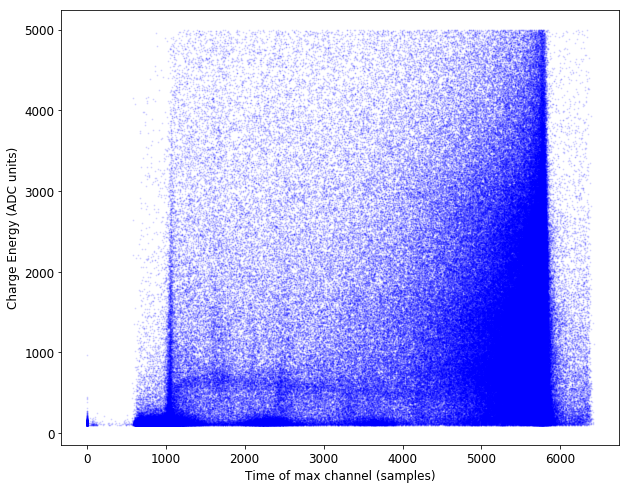

In [16]:

charge_energy = data_df['TotalTileEnergy']
time_of_max_channel = data_df['TimeOfMaxChannel']

#data can also be selected for example a specific energy range
mask = (data_df['TotalTileEnergy']>100) & (data_df['TotalTileEnergy']<5000)\
& (data_df['TotalSiPMEnergy']>100) & (data_df['TotalSiPMEnergy']<40000)

#make a 2d histogram with the selected data (for example charge energy vs light energy)

xbins = np.linspace(0.,6500.,200)
ybins = np.linspace(0.,5000.,100)

#plt.hist2d(time_of_max_channel[mask], charge_energy[mask],bins=(xbins,ybins))
plt.plot(time_of_max_channel[mask], charge_energy[mask],'o',color=(0.,0.,1.,0.1),markersize=1.)

plt.xlabel('Time of max channel (samples)')
plt.ylabel('Charge Energy (ADC units)')

Here we see a couple of features worth noting:
* There are two distinct cutoffs on the "time" axis, which correspond to the top and bottom of the detector. The trigger is at 1000 samples, so events near 1000 samples come from interactions just below the anode. Events near ~6000 samples come from the cathode (at the bottom).
* We can see a band at ~600ADC in the Charge Energy spectrum, which corresponds to the alpha signals from Bi212 decays.


We'll do two things to clean this up a bit. First, let's convert the X-axis into something a bit more meaningful -- the actual drift time.

Text(0, 0.5, 'Charge Energy (ADC units)')

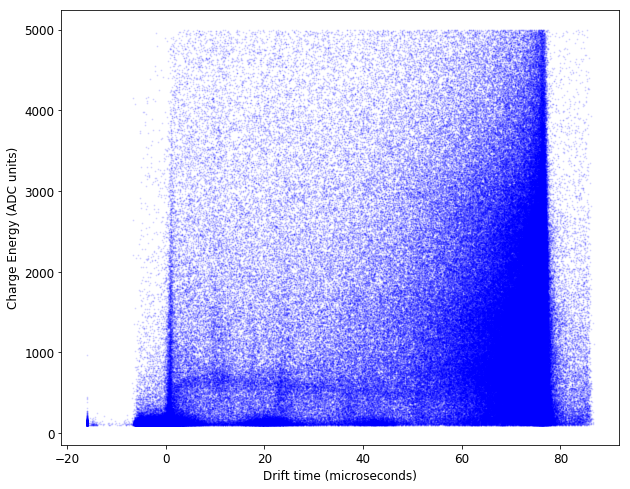

In [17]:
drift_time = (time_of_max_channel - analysis_config.run_parameters['Pretrigger Length [samples]']) \
               * analysis_config.run_parameters['Sampling Period [ns]'] / 1000.


#plt.hist2d(time_of_max_channel[mask], charge_energy[mask],bins=(xbins,ybins))
plt.plot(drift_time[mask], charge_energy[mask],'o',color=(0.,0.,1.,0.1),markersize=1.)

plt.xlabel('Drift time (microseconds)')
plt.ylabel('Charge Energy (ADC units)')


Next, we can select events where the charge is only on one or two channels. This should be the case for most alpha events, since the ionization is so localized. 




Text(0, 0.5, 'Charge Energy (ADC units)')

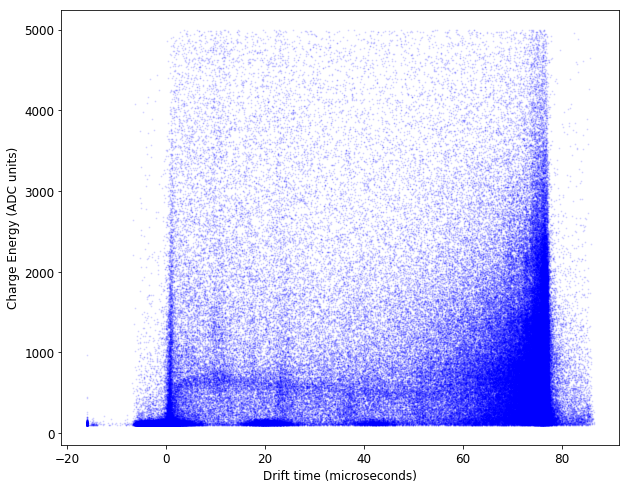

In [18]:
mask = (data_df['TotalTileEnergy']>100) & (data_df['TotalTileEnergy']<5000) \
        & (data_df['TotalSiPMEnergy']>100) & (data_df['TotalSiPMEnergy']<40000) \
        & (data_df['NumTileChannelsHit'] < 3)

#plt.hist2d(time_of_max_channel[mask], charge_energy[mask],bins=(xbins,ybins))
plt.plot(drift_time[mask], charge_energy[mask],'o',color=(0.,0.,1.,0.1),markersize=1.)

plt.xlabel('Drift time (microseconds)')
plt.ylabel('Charge Energy (ADC units)')


<a id="inspectingwaveforms"></a>

# Inspecting waveforms in the raw data

Sometimes it's useful to go back to the waveform-level information to better understand some feature in the reduced data. There is a class called `Event` in the `StanfordTPCAnalysis.WaveformAnalysis.Waveform` module that allows the easy plotting of all the waveforms in a given event.

For this to work, you need access to the ROOT files with the raw waveform data. For now, these are all located on the LLNL cluster, but can be moved to SLAC if needed.


In [19]:




#the indexes of the events passing the cuts can be seen in this way 
cut_index = data_df[mask].index
#a waveform can be accessed in the following way, in this case the first event passing the cut
event = Waveform.Event(fname,\
                       '/p/lustre1/jacopod/29th/20200213_AfterRnInjection/tier1/',cut_index[0],\
                       run_parameters_file,\
                       calibrations_file,\
                       channel_map_file)
#the second parameter in the Event class is the location of the tier1 file, which is where the low level information
#are stored, such as the waveform. Make sure the dataset (in this case 20200213_AfterRnInjection matches with the one
#opened in the reduced_added.h5 file), the third parameter is the number of the event you want to see the waveform of

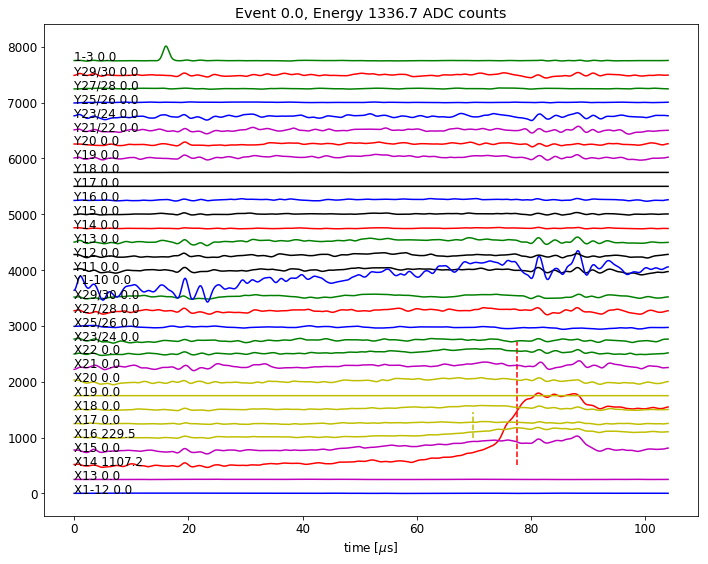

In [20]:
smoothing_windows_us = 0.5
#the waveform can be smoothed (just for visualization)
event.smooth(smoothing_windows_us)
plot = event.plot_event(risetime=True)
plot.show()